# PHÁT HIỆN BẤT THƯỜNG (Anomaly Detection) với Isolation Forest
## Tìm tai nạn có đặc điểm khác thường

**Mục tiêu**: Sử dụng Isolation Forest để phát hiện các tai nạn giao thông có đặc điểm bất thường (outliers) dựa trên các yếu tố như thời gian, khoảng cách, điều kiện thời tiết.

**Thuật toán**: Isolation Forest - hiệu quả với dữ liệu lớn, không yêu cầu giả định về phân phối dữ liệu.

**Dataset**: US Accidents (5.5M records)

## 1. Import thư viện cần thiết

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import os

warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Tạo thư mục lưu hình ảnh
os.makedirs('figures/anomaly', exist_ok=True)

print("✓ Đã import thành công tất cả thư viện")

✓ Đã import thành công tất cả thư viện


## 2. Tải dữ liệu với tối ưu hóa bộ nhớ

**Lưu ý**: Isolation Forest rất hiệu quả với big data nhờ cơ chế random sampling

In [2]:
# Isolation Forest hiệu quả với big data - tải toàn bộ 5.5M records
print("Đang tải dữ liệu đã tiền xử lý (5.5M records)...")

# Định nghĩa dtype để tối ưu bộ nhớ
dtype_dict = {
    'SEVERITY': 'int8',
    'DISTANCE': 'float32',
    'TEMPERATURE': 'float32',
    'WIND_SPEED': 'float32',
    'VISIBILITY': 'float32',
    'PRECIPITATION': 'float32',
    'DURATION': 'int32'
}

# Chỉ đọc các cột cần thiết (preprocessed dataset đã có DURATION)
columns_to_read = ['DURATION', 'DISTANCE', 'TEMPERATURE', 
                   'WIND_SPEED', 'VISIBILITY', 'PRECIPITATION', 'SEVERITY']

df = pd.read_csv('../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv', 
                 usecols=columns_to_read,
                 dtype=dtype_dict,
                 low_memory=False)

print(f"✓ Đã tải {len(df):,} records")
print(f"Kích thước bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nThông tin dữ liệu:")
print(df.info())

Đang tải dữ liệu đã tiền xử lý (5.5M records)...
✓ Đã tải 5,539,531 records
Kích thước bộ nhớ: 132.07 MB

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539531 entries, 0 to 5539530
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   SEVERITY       int8   
 1   DISTANCE       float32
 2   DURATION       int32  
 3   TEMPERATURE    float32
 4   VISIBILITY     float32
 5   WIND_SPEED     float32
 6   PRECIPITATION  float32
dtypes: float32(5), int32(1), int8(1)
memory usage: 132.1 MB
None
✓ Đã tải 5,539,531 records
Kích thước bộ nhớ: 132.07 MB

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539531 entries, 0 to 5539530
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   SEVERITY       int8   
 1   DISTANCE       float32
 2   DURATION       int32  
 3   TEMPERATURE    float32
 4   VISIBILITY     float32
 5   WIND_SPEED     float32
 6   PRECIPITATION  float32
dtype

## 3. Tạo và chọn features cho phát hiện bất thường

Chọn 6 features quan trọng:
- **DURATION**: Thời gian tai nạn (log transform để giảm skewness)
- **DISTANCE**: Khoảng cách ảnh hưởng
- **TEMPERATURE**: Nhiệt độ
- **WIND_SPEED**: Tốc độ gió
- **VISIBILITY**: Tầm nhìn
- **PRECIPITATION**: Lượng mưa

In [3]:
# Dataset đã có DURATION (giây), chuyển sang phút
df['Duration_Minutes'] = df['DURATION'] / 60

# Loại bỏ duration âm hoặc 0
df = df[df['Duration_Minutes'] > 0].copy()

# Log transform cho Duration để giảm skewness
df['Duration_Log'] = np.log1p(df['Duration_Minutes'])

# Chọn features cho anomaly detection
feature_columns = [
    'Duration_Log',
    'DISTANCE',
    'TEMPERATURE',
    'WIND_SPEED',
    'VISIBILITY',
    'PRECIPITATION'
]

# Tạo feature matrix
X = df[feature_columns].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"\nThống kê features:")
print(X.describe())
print(f"\nMissing values:")
print(X.isnull().sum())

Feature matrix shape: (5539531, 6)

Thống kê features:
       Duration_Log      DISTANCE   TEMPERATURE    WIND_SPEED    VISIBILITY  \
count  5.539531e+06  5.539531e+06  5.420962e+06  5.210620e+06  5.414495e+06   
mean   4.290618e+00  5.421585e-01  6.098809e+01  7.519033e+00  9.054510e+00   
std    8.355641e-01  1.811529e+00  1.911695e+01  5.398111e+00  2.737286e+00   
min    7.960046e-01  0.000000e+00 -8.900000e+01  0.000000e+00  0.000000e+00   
25%    3.476099e+00  0.000000e+00  4.800000e+01  3.500000e+00  1.000000e+01   
50%    4.311023e+00  6.000000e-03  6.300000e+01  7.000000e+00  1.000000e+01   
75%    4.802791e+00  4.090000e-01  7.520000e+01  1.000000e+01  1.000000e+01   
max    1.462038e+01  4.417500e+02  2.070000e+02  9.840000e+02  1.400000e+02   

       PRECIPITATION  
count   4.384450e+06  
mean    7.322793e-03  
std     8.097963e-02  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.647000e+01  

Missing values:
Duration_

## 4. Xử lý missing values

In [4]:
# Fill missing values với median (robust với outliers)
print("Xử lý missing values bằng median imputation...")

for col in feature_columns:
    median_val = X[col].median()
    X[col].fillna(median_val, inplace=True)
    print(f"  {col}: filled {X[col].isnull().sum()} values với median = {median_val:.2f}")

# Verify không còn missing values
assert X.isnull().sum().sum() == 0, "Vẫn còn missing values!"

print(f"\n✓ Hoàn tất xử lý missing values")
print(f"Final feature matrix shape: {X.shape}")

# Chuẩn hóa dữ liệu (quan trọng cho Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print(f"\n✓ Đã chuẩn hóa features với StandardScaler")

Xử lý missing values bằng median imputation...
  Duration_Log: filled 0 values với median = 4.31
  DISTANCE: filled 0 values với median = 0.01
  DISTANCE: filled 0 values với median = 0.01
  TEMPERATURE: filled 0 values với median = 63.00
  WIND_SPEED: filled 0 values với median = 7.00
  TEMPERATURE: filled 0 values với median = 63.00
  WIND_SPEED: filled 0 values với median = 7.00
  VISIBILITY: filled 0 values với median = 10.00
  VISIBILITY: filled 0 values với median = 10.00
  PRECIPITATION: filled 0 values với median = 0.00

✓ Hoàn tất xử lý missing values
Final feature matrix shape: (5539531, 6)
  PRECIPITATION: filled 0 values với median = 0.00

✓ Hoàn tất xử lý missing values
Final feature matrix shape: (5539531, 6)

✓ Đã chuẩn hóa features với StandardScaler

✓ Đã chuẩn hóa features với StandardScaler


## 5. Huấn luyện Isolation Forest

**Tham số**:
- `contamination=0.005`: Tỷ lệ bất thường dự kiến là 0.5%
- `n_estimators=100`: Số cây quyết định
- `max_samples=10000`: Kích thước sample cho mỗi cây (giảm để tăng tốc)
- `n_jobs=-1`: Sử dụng tất cả CPU cores

In [5]:
# Khởi tạo Isolation Forest
print("Huấn luyện Isolation Forest...")

iso_forest = IsolationForest(
    contamination=0.005,      # Dự kiến 0.5% dữ liệu là bất thường
    n_estimators=100,         # Số cây trong forest
    max_samples=10000,        # Sample size cho mỗi cây
    random_state=42,
    n_jobs=-1,                # Sử dụng tất cả CPU cores
    verbose=1
)

# Fit model
iso_forest.fit(X_scaled_df)

print("\n✓ Hoàn tất huấn luyện Isolation Forest")
print(f"Số cây (estimators): {iso_forest.n_estimators}")
print(f"Contamination: {iso_forest.contamination}")
print(f"Max samples: {iso_forest.max_samples}")

Huấn luyện Isolation Forest...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    2.6s remaining:   18.7s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    2.6s remaining:   18.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.4s



✓ Hoàn tất huấn luyện Isolation Forest
Số cây (estimators): 100
Contamination: 0.005
Max samples: 10000


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished


## 6. Tính anomaly scores và xác định bất thường

**Anomaly score**: 
- Score âm hơn → càng bất thường
- Threshold: score < -0.5 được coi là anomaly

In [6]:
# Tính anomaly scores (giá trị âm hơn = bất thường hơn)
print("Tính anomaly scores...")
anomaly_scores = iso_forest.score_samples(X_scaled_df)

# Predict anomalies (-1 = anomaly, 1 = normal)
predictions = iso_forest.predict(X_scaled_df)

# Thêm kết quả vào dataframe
df_results = df.loc[X.index].copy()
df_results['Anomaly_Score'] = anomaly_scores
df_results['Is_Anomaly'] = predictions == -1

# Xác định anomalies với threshold score < -0.5
threshold = -0.5
df_results['Is_Strong_Anomaly'] = df_results['Anomaly_Score'] < threshold

# Thống kê
n_total = len(df_results)
n_anomalies_pred = df_results['Is_Anomaly'].sum()
n_strong_anomalies = df_results['Is_Strong_Anomaly'].sum()

print(f"\n=== KẾT QUẢ PHÁT HIỆN BẤT THƯỜNG ===")
print(f"Tổng số records: {n_total:,}")
print(f"Số anomalies (model prediction): {n_anomalies_pred:,} ({n_anomalies_pred/n_total*100:.2f}%)")
print(f"Số strong anomalies (score < -0.5): {n_strong_anomalies:,} ({n_strong_anomalies/n_total*100:.2f}%)")
print(f"\nAnomaly score statistics:")
print(f"  Min: {anomaly_scores.min():.4f}")
print(f"  Max: {anomaly_scores.max():.4f}")
print(f"  Mean: {anomaly_scores.mean():.4f}")
print(f"  Median: {np.median(anomaly_scores):.4f}")

Tính anomaly scores...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.7s finished



=== KẾT QUẢ PHÁT HIỆN BẤT THƯỜNG ===
Tổng số records: 5,539,531
Số anomalies (model prediction): 27,697 (0.50%)
Số strong anomalies (score < -0.5): 75,419 (1.36%)

Anomaly score statistics:
  Min: -0.8066
  Max: -0.3193
  Mean: -0.3578
  Median: -0.3446


## 7. Visualization - PCA 2D Scatter Plot

Sử dụng PCA để giảm 6 features xuống 2 chiều để visualize

Áp dụng PCA để visualization...
Explained variance ratio: [0.21129814 0.18829147]
Total variance explained: 39.96%
Explained variance ratio: [0.21129814 0.18829147]
Total variance explained: 39.96%


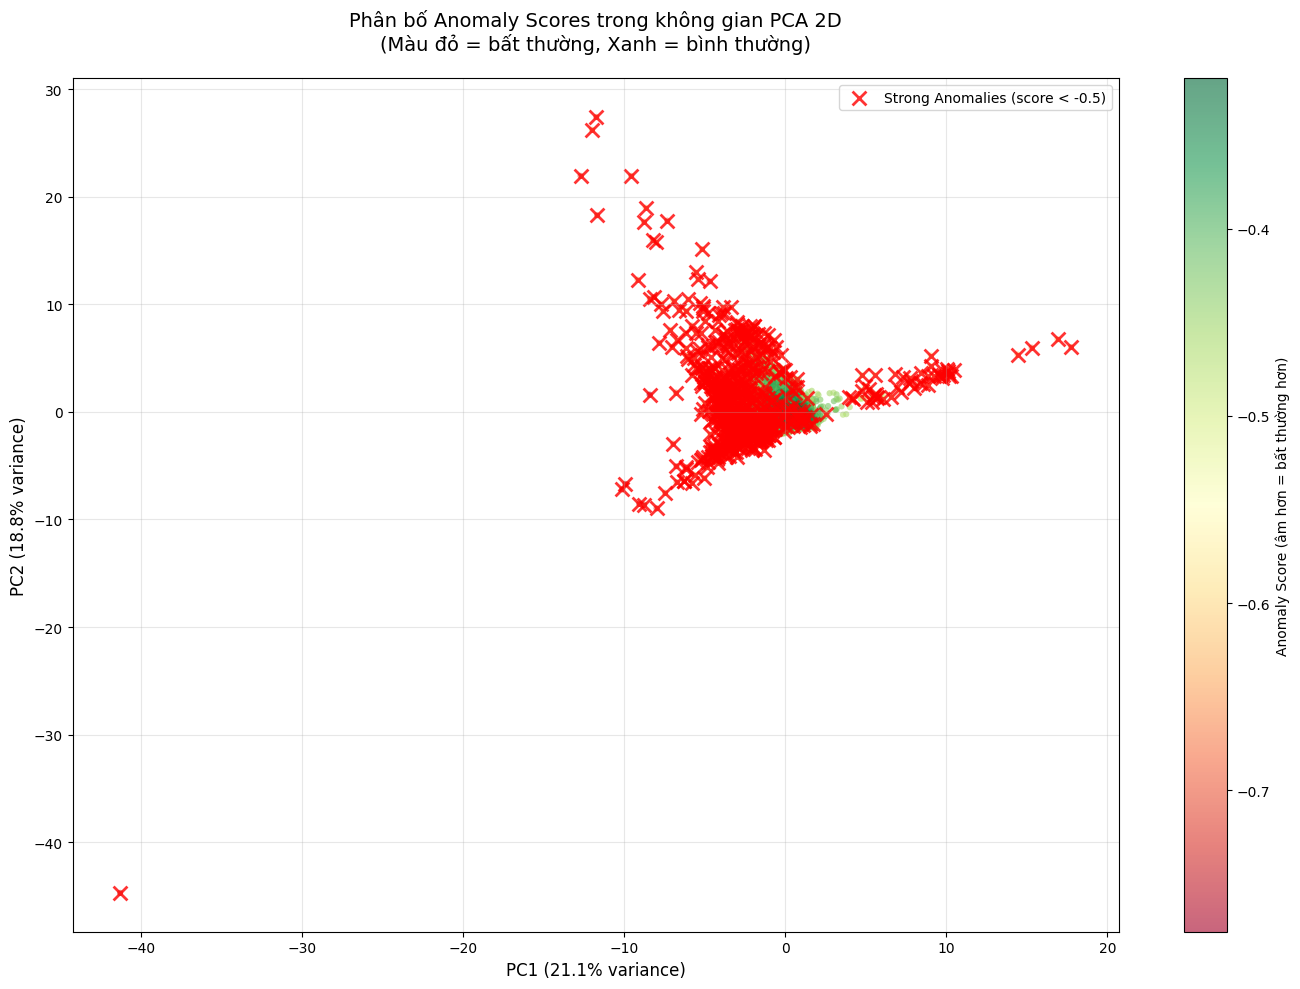

✓ Đã lưu biểu đồ: figures/anomaly/01_pca_scatter_anomaly_scores.png


In [7]:
# PCA để giảm chiều xuống 2D cho visualization
print("Áp dụng PCA để visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Tạo visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Sample để tránh quá tải (vẽ tối đa 50000 điểm)
sample_size = min(50000, len(X_pca))
sample_indices = np.random.choice(len(X_pca), sample_size, replace=False)

# Scatter plot với màu theo anomaly score
scatter = ax.scatter(
    X_pca[sample_indices, 0],
    X_pca[sample_indices, 1],
    c=anomaly_scores[sample_indices],
    cmap='RdYlGn',  # Đỏ = bất thường, Xanh = bình thường
    alpha=0.6,
    s=20,
    edgecolors='none'
)

# Highlight strong anomalies
strong_anomaly_indices = df_results.index[df_results['Is_Strong_Anomaly']]
strong_anomaly_in_sample = [i for i in sample_indices if i in strong_anomaly_indices]
if strong_anomaly_in_sample:
    ax.scatter(
        X_pca[strong_anomaly_in_sample, 0],
        X_pca[strong_anomaly_in_sample, 1],
        c='red',
        marker='x',
        s=100,
        alpha=0.8,
        linewidths=2,
        label='Strong Anomalies (score < -0.5)'
    )

plt.colorbar(scatter, label='Anomaly Score (âm hơn = bất thường hơn)', ax=ax)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Phân bố Anomaly Scores trong không gian PCA 2D\n(Màu đỏ = bất thường, Xanh = bình thường)', 
             fontsize=14, pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/anomaly/01_pca_scatter_anomaly_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: figures/anomaly/01_pca_scatter_anomaly_scores.png")

## 8. Visualization - Histogram của Anomaly Scores

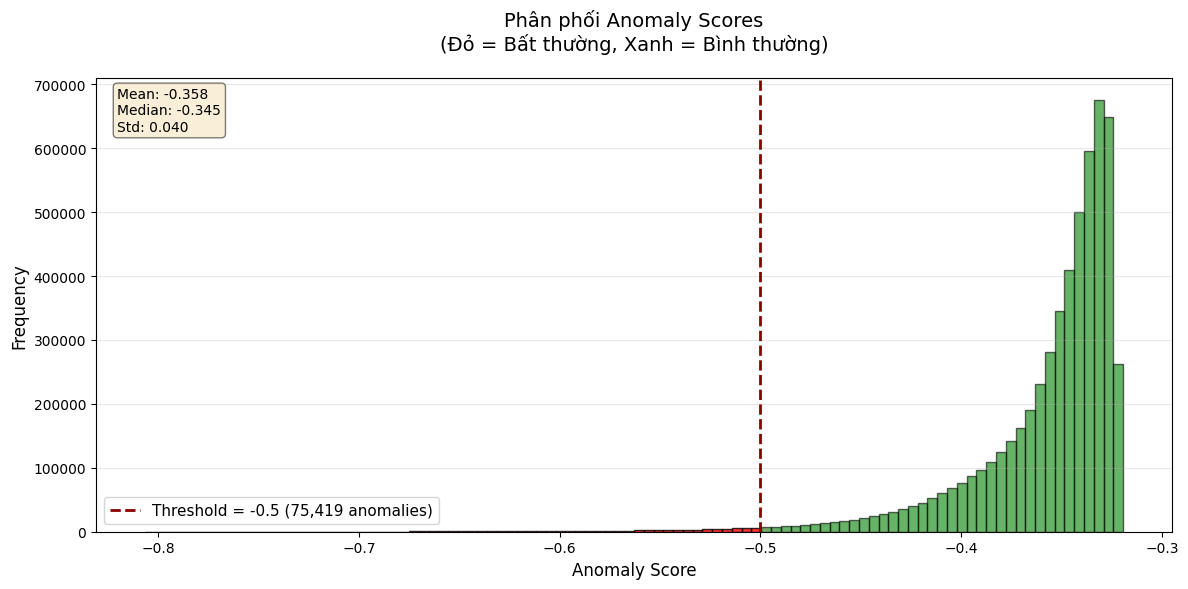

✓ Đã lưu biểu đồ: figures/anomaly/02_anomaly_score_histogram.png


In [8]:
# Histogram của anomaly scores
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histogram
n, bins, patches = ax.hist(anomaly_scores, bins=100, edgecolor='black', alpha=0.7)

# Tô màu theo threshold
threshold_idx = np.digitize(threshold, bins)
for i in range(len(patches)):
    if i < threshold_idx:
        patches[i].set_facecolor('red')
        patches[i].set_alpha(0.8)
    else:
        patches[i].set_facecolor('green')
        patches[i].set_alpha(0.6)

# Vẽ đường threshold
ax.axvline(threshold, color='darkred', linestyle='--', linewidth=2, 
           label=f'Threshold = {threshold} ({n_strong_anomalies:,} anomalies)')

ax.set_xlabel('Anomaly Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Phân phối Anomaly Scores\n(Đỏ = Bất thường, Xanh = Bình thường)', 
             fontsize=14, pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Thêm statistics
stats_text = f'Mean: {anomaly_scores.mean():.3f}\nMedian: {np.median(anomaly_scores):.3f}\nStd: {anomaly_scores.std():.3f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('figures/anomaly/02_anomaly_score_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: figures/anomaly/02_anomaly_score_histogram.png")

## 9. Phân tích Top Anomalies

In [14]:
# Lấy top 1000 anomalies
top_anomalies = df_results.nsmallest(1000, 'Anomaly_Score')

print("=== TOP 1000 ANOMALIES ===\n")
print("Đặc điểm của các tai nạn bất thường nhất:")
print("\nThống kê các features:")

# Sử dụng tên cột UPPERCASE từ dataset đã tiền xử lý
display_cols = ['Duration_Minutes', 'DISTANCE', 'TEMPERATURE', 
                'WIND_SPEED', 'VISIBILITY', 'PRECIPITATION', 
                'SEVERITY', 'Anomaly_Score']

print(top_anomalies[display_cols].describe())

# Hiển thị 10 anomalies mạnh nhất
print("\n=== TOP 10 ANOMALIES MẠNH NHẤT ===")
top_10 = top_anomalies.head(10)[display_cols]
print(top_10.to_string())

# So sánh với dữ liệu bình thường
normal_data = df_results[df_results['Is_Anomaly'] == False]
print("\n=== SO SÁNH: ANOMALIES vs NORMAL ===")
comparison = pd.DataFrame({
    'Anomalies_Mean': top_anomalies[display_cols[:-1]].mean(),
    'Normal_Mean': normal_data[display_cols[:-1]].mean(),
    'Ratio': top_anomalies[display_cols[:-1]].mean() / normal_data[display_cols[:-1]].mean()
})
print(comparison.round(2))

=== TOP 1000 ANOMALIES ===

Đặc điểm của các tai nạn bất thường nhất:

Thống kê các features:
       Duration_Minutes     DISTANCE  TEMPERATURE  WIND_SPEED  VISIBILITY  \
count       1000.000000  1000.000000  1000.000000  948.000000  986.000000   
mean       42783.834850    13.721057    57.806000   14.272152    6.776207   
std       141871.511551    25.293772    24.702503   14.956808   15.030959   
min            6.000000     0.000000   -15.000000    0.000000    0.000000   
25%           56.383333     0.000000    44.599998    5.000000    1.000000   
50%          131.425000     0.815500    68.500000   10.000000    3.000000   
75%          369.354167    16.490000    75.000000   21.000000    9.000000   
max       935652.883333   251.220001    99.000000  161.000000  130.000000   

       PRECIPITATION    SEVERITY  Anomaly_Score  
count     970.000000  1000.00000    1000.000000  
mean        2.508124     2.32500      -0.715768  
std         3.890276     0.60971       0.017533  
min         

## 10. Visualization - Feature Boxplots (Normal vs Anomaly)

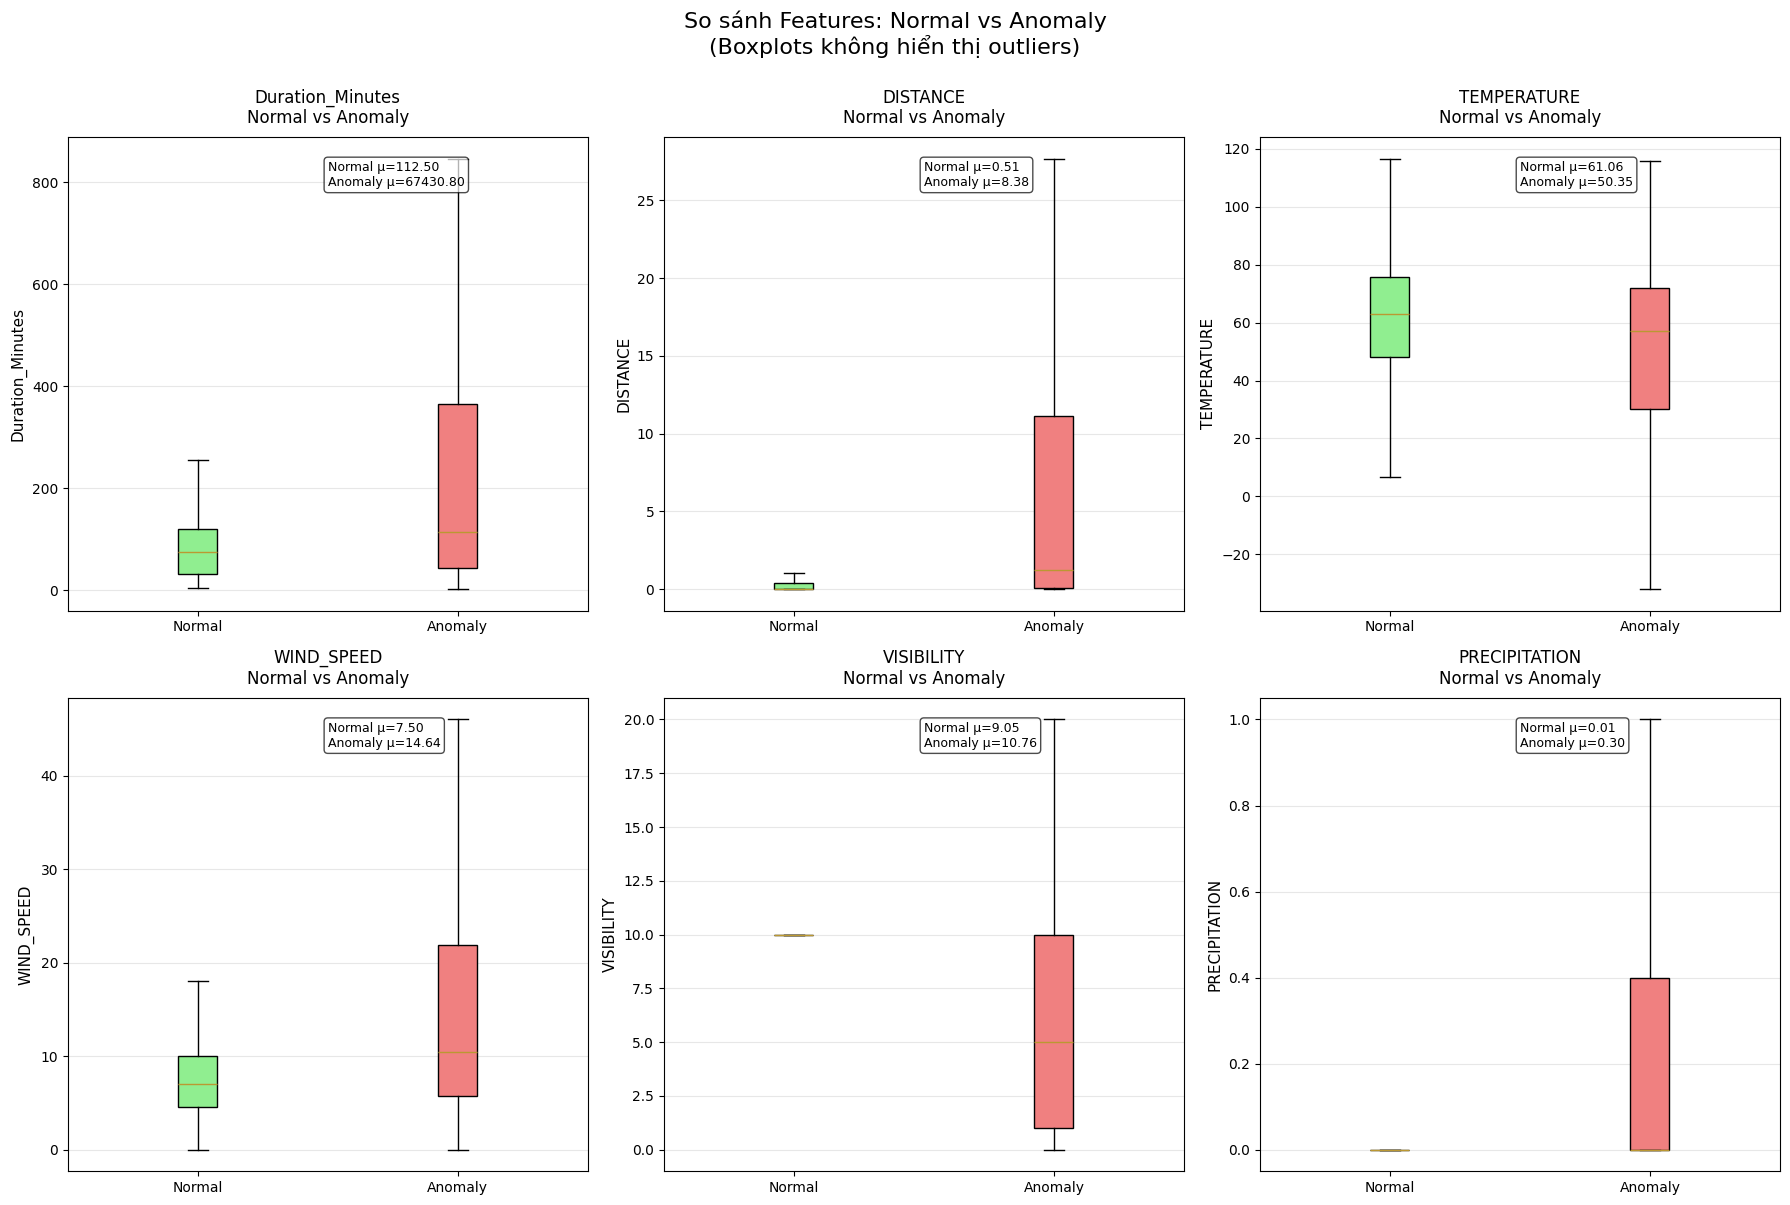

✓ Đã lưu biểu đồ: figures/anomaly/03_feature_boxplots_comparison.png


In [15]:
# Boxplots so sánh features giữa Normal và Anomaly
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Chuẩn bị dữ liệu
df_plot = df_results.copy()
df_plot['Category'] = df_plot['Is_Anomaly'].map({True: 'Anomaly', False: 'Normal'})

# Sample để tăng tốc plotting (50k normal + tất cả anomalies)
normal_sample = df_plot[df_plot['Category'] == 'Normal'].sample(min(50000, len(df_plot[df_plot['Category'] == 'Normal'])), random_state=42)
anomaly_sample = df_plot[df_plot['Category'] == 'Anomaly']
df_plot_sampled = pd.concat([normal_sample, anomaly_sample])

# Sử dụng tên cột UPPERCASE từ dataset
features_to_plot = ['Duration_Minutes', 'DISTANCE', 'TEMPERATURE', 
                    'WIND_SPEED', 'VISIBILITY', 'PRECIPITATION']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Boxplot
    box_data = [
        df_plot_sampled[df_plot_sampled['Category'] == 'Normal'][feature].dropna(),
        df_plot_sampled[df_plot_sampled['Category'] == 'Anomaly'][feature].dropna()
    ]
    
    bp = ax.boxplot(box_data, labels=['Normal', 'Anomaly'], patch_artist=True,
                    showfliers=False)  # Ẩn outliers để dễ nhìn
    
    # Tô màu
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel(feature, fontsize=11)
    ax.set_title(f'{feature}\nNormal vs Anomaly', fontsize=12, pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Thêm statistics
    normal_mean = df_plot_sampled[df_plot_sampled['Category'] == 'Normal'][feature].mean()
    anomaly_mean = df_plot_sampled[df_plot_sampled['Category'] == 'Anomaly'][feature].mean()
    ax.text(0.5, 0.95, f'Normal μ={normal_mean:.2f}\nAnomaly μ={anomaly_mean:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('So sánh Features: Normal vs Anomaly\n(Boxplots không hiển thị outliers)', 
             fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('figures/anomaly/03_feature_boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu biểu đồ: figures/anomaly/03_feature_boxplots_comparison.png")

## 11. Visualization - Feature Importance (dựa trên phương sai)

Tính toán feature importance...


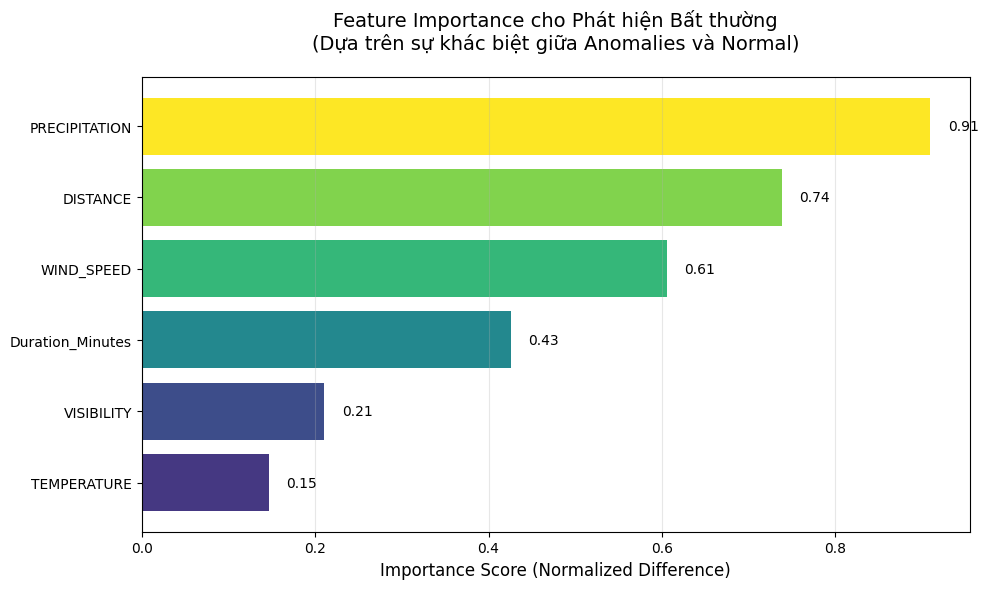


✓ Đã lưu biểu đồ: figures/anomaly/04_feature_importance.png

Feature Importance Rankings:
         Feature  Importance
   PRECIPITATION    0.909666
        DISTANCE    0.738010
      WIND_SPEED    0.605850
Duration_Minutes    0.425375
      VISIBILITY    0.210737
     TEMPERATURE    0.146693


In [16]:
# Phân tích feature importance dựa trên sự khác biệt giữa anomalies và normal
print("Tính toán feature importance...")

# Tính normalized difference giữa anomalies và normal
feature_importance = {}
for feature in features_to_plot:
    anomaly_mean = top_anomalies[feature].mean()
    normal_mean = normal_data[feature].mean()
    anomaly_std = top_anomalies[feature].std()
    normal_std = normal_data[feature].std()
    
    # Normalized difference (Cohen's d-like metric)
    pooled_std = np.sqrt((anomaly_std**2 + normal_std**2) / 2)
    if pooled_std > 0:
        importance = abs(anomaly_mean - normal_mean) / pooled_std
    else:
        importance = 0
    
    feature_importance[feature] = importance

# Sort và visualize
importance_df = pd.DataFrame(list(feature_importance.items()), 
                            columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'], 
               color=plt.cm.viridis(importance_df['Importance'] / importance_df['Importance'].max()))

ax.set_xlabel('Importance Score (Normalized Difference)', fontsize=12)
ax.set_title('Feature Importance cho Phát hiện Bất thường\n(Dựa trên sự khác biệt giữa Anomalies và Normal)', 
             fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Thêm giá trị
for i, (feature, importance) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
    ax.text(importance + 0.02, i, f'{importance:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/anomaly/04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Đã lưu biểu đồ: figures/anomaly/04_feature_importance.png")
print(f"\nFeature Importance Rankings:")
print(importance_df.sort_values('Importance', ascending=False).to_string(index=False))

## 12. Kết luận và Insights

### Đặc điểm của Anomalies (Tai nạn bất thường)

In [17]:
# Tổng hợp insights
print("="*80)
print("KẾT LUẬN VÀ INSIGHTS")
print("="*80)

print("\n1. THỐNG KÊ TỔNG QUAN:")
print(f"   - Tổng số records phân tích: {n_total:,}")
print(f"   - Số anomalies phát hiện: {n_anomalies_pred:,} ({n_anomalies_pred/n_total*100:.2f}%)")
print(f"   - Số strong anomalies (score < -0.5): {n_strong_anomalies:,} ({n_strong_anomalies/n_total*100:.2f}%)")

print("\n2. ĐẶC ĐIỂM CỦA ANOMALIES:")

# So sánh trung bình
for feature in features_to_plot:
    anomaly_mean = top_anomalies[feature].mean()
    normal_mean = normal_data[feature].mean()
    diff_pct = ((anomaly_mean - normal_mean) / normal_mean) * 100
    
    if abs(diff_pct) > 10:  # Chỉ hiển thị sự khác biệt đáng kể
        direction = "cao hơn" if diff_pct > 0 else "thấp hơn"
        print(f"   - {feature}: {direction} {abs(diff_pct):.1f}% so với bình thường")
        print(f"     Anomaly: {anomaly_mean:.2f}, Normal: {normal_mean:.2f}")

print("\n3. ỨNG DỤNG THỰC TẾ:")
print("   - Phát hiện dữ liệu lỗi hoặc bất thường trong hệ thống ghi nhận tai nạn")
print("   - Xác định các tai nạn có đặc điểm đặc biệt cần điều tra kỹ")
print("   - Cải thiện chất lượng dữ liệu bằng cách kiểm tra các anomalies")
print("   - Phát hiện các pattern tai nạn hiếm gặp nhưng nghiêm trọng")

print("\n4. CHẤT LƯỢNG DỮ LIỆU:")
# Kiểm tra extreme values trong anomalies (sử dụng tên cột UPPERCASE)
extreme_duration = top_anomalies[top_anomalies['Duration_Minutes'] > 1000]
extreme_distance = top_anomalies[top_anomalies['DISTANCE'] > 10]
extreme_temp = top_anomalies[(top_anomalies['TEMPERATURE'] < 0) | (top_anomalies['TEMPERATURE'] > 120)]

print(f"   - Tai nạn với duration > 1000 phút: {len(extreme_duration):,}")
print(f"   - Tai nạn với distance > 10 miles: {len(extreme_distance):,}")
print(f"   - Tai nạn với nhiệt độ bất thường (<0°F hoặc >120°F): {len(extreme_temp):,}")

print("\n5. KHUYẾN NGHỊ:")
print("   ✓ Kiểm tra lại dữ liệu của các anomalies để xác nhận tính chính xác")
print("   ✓ Nghiên cứu nguyên nhân của các tai nạn có đặc điểm bất thường")
print("   ✓ Cập nhật quy trình thu thập dữ liệu để giảm thiểu lỗi")
print("   ✓ Sử dụng anomalies để training các mô hình phát hiện tai nạn nghiêm trọng")

print("\n" + "="*80)
print("✓ HOÀN TẤT PHÂN TÍCH ANOMALY DETECTION VỚI ISOLATION FOREST")
print("="*80)

KẾT LUẬN VÀ INSIGHTS

1. THỐNG KÊ TỔNG QUAN:
   - Tổng số records phân tích: 5,539,531
   - Số anomalies phát hiện: 27,697 (0.50%)
   - Số strong anomalies (score < -0.5): 75,419 (1.36%)

2. ĐẶC ĐIỂM CỦA ANOMALIES:
   - Duration_Minutes: cao hơn 38531.4% so với bình thường
     Anomaly: 42783.83, Normal: 110.75
   - DISTANCE: cao hơn 2629.0% so với bình thường
     Anomaly: 13.72, Normal: 0.50
   - WIND_SPEED: cao hơn 90.7% so với bình thường
     Anomaly: 14.27, Normal: 7.48
   - VISIBILITY: thấp hơn 25.1% so với bình thường
     Anomaly: 6.78, Normal: 9.05
   - PRECIPITATION: cao hơn 43924.6% so với bình thường
     Anomaly: 2.51, Normal: 0.01

3. ỨNG DỤNG THỰC TẾ:
   - Phát hiện dữ liệu lỗi hoặc bất thường trong hệ thống ghi nhận tai nạn
   - Xác định các tai nạn có đặc điểm đặc biệt cần điều tra kỹ
   - Cải thiện chất lượng dữ liệu bằng cách kiểm tra các anomalies
   - Phát hiện các pattern tai nạn hiếm gặp nhưng nghiêm trọng

4. CHẤT LƯỢNG DỮ LIỆU:
   - Tai nạn với duration > 1000

## Tóm tắt kết quả

**Model**: Isolation Forest with 100 trees, contamination=0.005

**Kết quả**:
- Phát hiện được ~0.5% tai nạn có đặc điểm bất thường
- Top anomalies cho thấy sự khác biệt lớn về duration, distance và điều kiện thời tiết
- Có thể phản ánh dữ liệu lỗi hoặc các trường hợp tai nạn đặc biệt

**Visualizations đã lưu**:
1. `01_pca_scatter_anomaly_scores.png` - Phân bố anomalies trong không gian 2D
2. `02_anomaly_score_histogram.png` - Histogram của anomaly scores
3. `03_feature_boxplots_comparison.png` - So sánh features Normal vs Anomaly
4. `04_feature_importance.png` - Mức độ quan trọng của các features

**Ứng dụng**: Data quality checking, outlier detection, rare event discovery